
# 문제정의
이 대회는 많은 사람을 죽음으로 몰고 간 `Titanic 호 침몰 사건`을 주제로 다룬다.


생존에 영향을 미친 여러 요인이 있겠지만, 대회에서 주어진 Train 승객들의 정보만으로 Test 승객들의 생존 여부를 예측해보려고 한다.


생존과 연루되어 있다고 생각되는 몇 가지의 요소들에 대해 분석하여 어떤 조건을 갖춘 그룹들이 생존할 확률이 더 높았는지에 대해 알아보려고 한다.




# 데이터 수집

In [267]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
from collections import Counter
import matplotlib as mpl
import random
from copy import deepcopy
from collections import defaultdict
from pandas.plotting import parallel_coordinates
warnings.filterwarnings(action = 'ignore')
plt.rcParams['font.family'] = 'KBIZmjo M'
%matplotlib inline

In [268]:
train = pd.read_csv('Desktop/데이터분석/titanic/train.csv')
test = pd.read_csv('Desktop/데이터분석/titanic/test.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [269]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [270]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

----------------------------------------------------
총 891명의 탑승자가 있다.(학습대상) 



하지만 Age, Cabin, Embarked는 몇몇 탑승자들의 정보가 누락되어있다.

- Age : 177명 누락(약 20%)
- Cabin : 687명 누락(약 77%)
- Embarked : 2명 누락(약 0.2%)


In [271]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [272]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

---------------------------------------------
test탑승자의 정보도 일부 누락되어있다. --> Age, Fare, Cabin  

In [273]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [274]:
Dead_num = 549
Survived_num = 342

-----------------------------------------
전체 train탑승객 중 사망자는 549명, 생존자는 342명이다.

# 데이터 전처리
데이터를 다루기 쉽도록 가공한다.

- 중복데이터 삭제

In [275]:
train = train.drop_duplicates()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [276]:
test = test.drop_duplicates()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


- 불필요한 컬럼 삭제

In [296]:
ticket_dict = defaultdict(list)
for t_num , p_id in zip(train.Ticket, train.PassengerId):
    ticket_dict[t_num].append(p_id)

In [278]:
cnt = 0 #동승자 수+1(자기자신)과 Ticket번호가 동일한 승객수와 맞지 않는 경우 count
sp_dict = defaultdict(list)#key : sibsp+parch , value : passengerid
for k,v in ticket_dict.items():
    for s1, s2, p_id in zip(train.loc[train['Ticket']==k, 'SibSp'],train.loc[train['Ticket']==k, 'Parch'], train.loc[train['Ticket']==k,'PassengerId']):
        sp_dict[s1+s2].append(p_id) 
        if s1+s2+1 != len(v):
            cnt += 1
print(cnt)

288


--------------------------------------------------------------------
동승자는 Ticket번호가 모두 같을 것이기에 

동일 Ticket번호 개수 = SibSp + Parch + 1(자기자신) 일것이라 생각했다.

그런데 둘의 값이 다른 승객이 288명으로 꽤 많다.


#### [SibSp+Parch VS Ticket]
내가 세운 가설인 '동승자가 있는 승객은 생존확률이 높을 것이다.'을 검증하는데 더 도움이 되는 쪽으로 택할 것이다.

In [279]:
#Ticket
t_survived = 0 #동일 Ticket을 가진 승객이 있고, 생존한 승객 count
t_tmp =0 #len(v) >1인 승객 count
for k,v in ticket_dict.items():
    if len(v) <=1:
        continue
    for vv in v: 
        t_tmp += 1 
        if int(train[train['PassengerId']==vv].Survived) == 1:
            t_survived += 1

t_surv_pct = t_survived / Survived_num
surv_t_pct = t_survived /t_tmp
print('P(t|surv) = ',t_surv_pct)
print('P(surv|t) = ',surv_t_pct)

P(t|surv) =  0.5233918128654971
P(surv|t) =  0.5203488372093024


------------------------------
즉, 생존자 중 동일 Ticket을 가진 승객이 있을 확률은 52.34%

동일 Ticket을 가진 승객이 있는 승객 중 생존자일 확률은 52.03% 

In [280]:
#SibSp+Parch
sp_survived = 0 #sibsp+parch >0 이고 생존한 승객 count
sp_tmp = 0 #k>0인 승객 count
for k,v in sp_dict.items():
    if k==0:
        continue
    for vv in v: 
        sp_tmp += 1 
        if int(train.loc[train.PassengerId == vv].Survived) == 1:
            sp_survived += 1
sp_surv_pct = sp_survived/Survived_num #생존자 중에서 sibsp + parch > 0인 승객
surv_sp_pct = sp_survived/sp_tmp #sibsp + parch >0 인 승객 중 생존자

print('P(sp|surv) = ',sp_surv_pct)
print('P(surv|sp) = ',surv_sp_pct)

P(sp|surv) =  0.5233918128654971
P(surv|sp) =  0.5056497175141242


------------------------------
생존자 중 동승한 SibSp or Parch가 있는 승객일 확률은 52.34%

동승한 SibSp or Parch가 있는 승객 중 생존자일 확률은 50.56%

In [281]:
#활용하지 않을 컬럼 drop
train = train.drop(['Name', 'SibSp', 'Parch' ], axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 69.6+ KB


In [282]:
test = test.drop(['Name', 'SibSp', 'Parch'], axis = 1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 29.4+ KB


----------------------------------
Name : 칭호를 분리해서 분석해볼 수 있지만 칭호는 Pclass, Fare 등 대체 할 수 있는 컬럼이 많기에 drop

SibSp, Parch : 동승자는 Ticket 컬럼 하나로 알아보는 것이 좋을 것 같다. Ticket으로는 동승자 수뿐만아니라 동승자의 정보까지 알아낼 수 있으므로 Ticket을 남겨두는 것이 더 좋은 선택이라 생각한다. 

- 데이터 타입 바꾸기

In [283]:
#알파벳 별 숫자 부여(대문자)
Cabin_dict = defaultdict(int)
for i,j in enumerate(range(65,91)):
    Cabin_dict[chr(j)] = i+1

In [284]:
#맨앞 알파벳만 따서 알파벳별 숫자 부여 (즉, string -> int)
for c, idx in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].index):
    train.set_value(idx,'Cabin', Cabin_dict[c[0].upper()])
train[train['Cabin'].notnull()].head(5)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked
1,2,1,1,female,38.0,PC 17599,71.2833,3,C
3,4,1,1,female,35.0,113803,53.1000,3,S
6,7,0,1,male,54.0,17463,51.8625,5,S
10,11,1,3,female,4.0,PP 9549,16.7000,7,S
11,12,1,1,female,58.0,113783,26.5500,3,S


In [285]:
#test도 적용
for c, idx in zip(test.loc[test.Cabin.notnull()].Cabin, test.loc[test.Cabin.notnull()].index):
    test.set_value(idx,'Cabin', Cabin_dict[c[0].upper()])
test[test['Cabin'].notnull()].head(5)

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked
12,904,1,female,23.0,21228,82.2667,2,S
14,906,1,female,47.0,W.E.P. 5734,61.1750,5,S
24,916,1,female,48.0,PC 17608,262.3750,2,C
26,918,1,female,22.0,113509,61.9792,2,C
28,920,1,male,41.0,113054,30.5000,1,S


In [286]:
for i in ['Sex', 'Embarked']:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
#string -> int
train['Sex'].cat.categories = [1,2]
test['Sex'].cat.categories = [1,2]
train['Embarked'].cat.categories = [1,2,3]
test['Embarked'].cat.categories = [1,2,3]

In [288]:
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked
0,1,0,3,2,22.0,A/5 21171,7.2500,NaN,3
1,2,1,1,1,38.0,PC 17599,71.2833,3,1
2,3,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,3
3,4,1,1,1,35.0,113803,53.1000,3,3
4,5,0,3,2,35.0,373450,8.0500,NaN,3


---------------
이제 Ticket을 제외한 나머지 컬럼의 데이터 타입은 int 또는 float이다.

- 결측치 처리

train 데이터)
    - Age : 다른 데이터로 추정하여 대체
    - Cabin : 일단 놔둠(분석 후 결정)
    - Embarked : 해당 행 삭제
    
test 데이터)
    - Age : 다른 데이터로 추정하여 대체
    - Fare : 다른 데이터로 추정하여 대체
    - Cabin : 일단 놔둠(분석 후 결정)
    

In [289]:
#Embarked결측치 삭제
train = train.drop(train.loc[train.Embarked.isnull()].index) 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            712 non-null float64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(3), object(2)
memory usage: 57.5+ KB


In [310]:
from sklearn.ensemble import RandomForestRegressor
def predict (dat, target, feature):#전체 데이터, 대상 컬럼, 예측에 활용될 컬럼list
    #target값이 Null인것과 Null이 아닌 것 구분
    Not_Null = dat.loc[dat[target].notnull()]
    Is_Null = dat.loc[dat[target].isnull()]
    
    Is_Null[target] = Is_Null[target].astype('str')
    
    #랜덤포레스트 분류기를 사용한다.
    rfModel = RandomForestRegressor()
    
    #feature에 있는 피처의 값을 바탕으로 학습시킨다.
    rfModel.fit(Not_Null[feature], Not_Null[target])
    
    #학습한 값을 바탕으로 예측한다.
    predicted_val = rfModel.predict(X = Is_Null[feature])
    
    #예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    Is_Null_cpy = Is_Null
    Not_Null_cpy= Not_Null
    
    #결측치가 있는 데이터 프레임에 예측값을 넣어줌
    Is_Null_cpy[target] = predicted_val
    
    #결측치가 없는 데이터 프레임에 예측한 값이 있는 데이터프레임을 합친다.
    dat = Not_Null_cpy.append(Is_Null_cpy)
    dat[target] = dat[target].astype('float')
    
    dat.reset_index(inplace = True)
    dat.drop('index', inplace = True, axis =1)
    return dat

In [308]:
#나이 예측
train_age = predict(train,'Age',['Pclass', 'Fare','Sex','Embarked'])
train_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            889 non-null float64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(3), object(2)
memory usage: 50.6+ KB


In [311]:
#나이 예측 후
train_age.Age.describe()

count    889.000000
mean      29.728046
std       13.569788
min        0.420000
25%       21.000000
50%       28.041410
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [313]:
#나이 예측 전
train.Age.describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [315]:
#test도 예측
#먼저 Fare부터
test = predict(test, 'Fare', ['Pclass','Sex'])
#이후 Age 예측
test_age = predict(test, 'Age', ['Pclass', 'Fare','Sex','Embarked'])
test_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null category
Age            418 non-null float64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null category
dtypes: category(2), float64(2), int64(2), object(2)
memory usage: 20.7+ KB


In [317]:
#예측 후
test_age.Age.describe()

count    418.000000
mean      29.540625
std       13.127189
min        0.170000
25%       21.769097
50%       27.000000
75%       36.375000
max       76.000000
Name: Age, dtype: float64

In [318]:
#예측 전
test.Age.describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64


# 데이터 마이닝
데이터를 다양한 방법으로 분석해보며 데이터의 패턴과 의미를 찾아낸다. 

In [14]:
def standardization(data): #표준화
    m = data.mean()
    s = data.std()
    return [(i-m)/s for i in data]

def normalization(data): #정규화
    minn = data.min()
    maxx = data.max()
    return[(i-minn)/(maxx-minn) for i in data]

In [15]:
def split_data(data,prob):
    #데이터를 [prob, 1-prob]비율로 나눔
    results = [], [] #이건 머지... (참고로 참고책은 파이선2.7)
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

def train_test_split(x,y,test_pct):
    data = zip (x,y) #데이터 포인트 하나에 해당하는 값들
    train, test = split_data() #데이터 셋을 나누기
    x_train, y_train = zip(*train)
    x_test, y_test  =  zip(*test)
    return x_train, x_test, y_train,y_test
    

In [16]:
# model = someKindOfModel()
# x_train, x_test, y_train, y_test= train_test_split(xs, ys, 0.33)
# model.train(x_train, y_train)
# performance = model.test(x_test, y_test)

In [17]:
train_d , test_d = split_data(train.drop(['Survived'], axis= 1),0.6)

In [18]:
train_d

['PassengerId', 'Parch', 'Fare']

In [19]:
test_d

['Pclass', 'Sex', 'Age', 'SibSp', 'Ticket', 'Cabin', 'Embarked']

In [20]:
#다수결 정하는 함수
def majority_vote(labels):
    votes = Counter(labels)
    print(votes)
    res, num = votes.most_common(1)[0]
    cnt = 0
    #동점 체크(labels가 거리 오름차순으로 정렬되었다는 가정하에)
    for v in votes.values():
        if v == num:
            cnt += 1
    if cnt > 1:
        return majority_vote(labels[:-1])
    return res

In [21]:
print(majority_vote(sorted([1,3,4,5,12,3,2,2,3,1,2,1])))

Counter({1: 3, 2: 3, 3: 3, 4: 1, 5: 1, 12: 1})
Counter({1: 3, 2: 3, 3: 3, 4: 1, 5: 1})
Counter({1: 3, 2: 3, 3: 3, 4: 1})
Counter({1: 3, 2: 3, 3: 3})
Counter({1: 3, 2: 3, 3: 2})
Counter({1: 3, 2: 3, 3: 1})
Counter({1: 3, 2: 3})
Counter({1: 3, 2: 2})
1


In [22]:
#연령대 분류 함수
def AgeClassify(k):
    if k<10.0: 
        return 0
    elif k<20.0:#10대
        return 10
    elif k<30.0:#20대
        return 20
    elif k<40.0:#30대
        return 30
    elif k<50.0:#40대
        return 40
    elif k<60.0:#50대
        return 50
    elif k<70.0:#60대
        return 60
    elif k<80.0:#70대
        return 70
    elif k>=80.0:
        return 80

## Null값 유무, 동승자 유무(SibSp + Parch), 사망 여부의 상관관계

- Null_ID : null값이 하나라도 있는 승객의 PassengerId


- Alone_ID : 동승자가 없는 승객의 PassengerId


- Null_Alone_num : Null_ID에 속하면서 Alone_ID에 속하는 승객 수


- Dead_Alone_ID : 사망자이면서 동승자가 없는 승객의 PassengerId


- Dead_Alone_Null_num : Dead_Alone_ID에 속하면서 Null_ID에 속하는 승객 수


- Dead_Null_num : 사망자이면서 null값이 있는 승객 수


- Alone_Null_num : Alone_Id에 속하면서 Null_ID에 속하는 승객 수


In [23]:
#null값이 하나라도 있으면 passengerid 저장
Null_ID = list(train.loc[train.Age.isnull()|train.Cabin.isnull()|train.Embarked.isnull()].PassengerId)
len(Null_ID)

708

In [24]:
#사망자와 생존자 카운트(null값이 하나라도 있는 승객 대상)
train.loc[train.Age.isnull()|train.Cabin.isnull()|train.Embarked.isnull()].Survived.value_counts()

0    489
1    219
Name: Survived, dtype: int64

In [25]:
489/708 #null값이 있는 승객 중 사망자는 69%

0.690677966101695

In [26]:
#null값이 있는 승객 중 동승자가 없는 승객 카운트
Null_Alone_num = 0
for n in Null_ID:
    num = 0
    num += train.loc[train.PassengerId == n].SibSp + train.loc[train.PassengerId == n].Parch
    if int(num) == 0:
        Null_Alone_num += 1
print("혼자온 승객 : {}". format(Null_Alone_num))

혼자온 승객 : 458


In [27]:
#사망자이고 동승자가 없는 승객
Dead_Alone_ID = train.loc[train.Survived == 0].loc[train.SibSp == 0].loc[train.Parch == 0].PassengerId
Dead_Alone_Null_num = 0 
for i in Dead_Alone_ID:
    if i in Null_ID:
        Dead_Alone_Null_num += 1
print("전체 승객 중 사망자이고 혼자 온 승객 수: {}".format(len(Dead_Alone_ID)))
print("위 승객 중 null값이 하나라도 있는 승객 수: {}".format(Dead_Alone_Null_num))
print((Dead_Alone_Null_num*100)/Dead_num)

전체 승객 중 사망자이고 혼자 온 승객 수: 374
위 승객 중 null값이 하나라도 있는 승객 수: 343
62.47723132969035


In [28]:
Dead_Null_num = 0
#사망자 중 null값이 있는 승객의 수
for i in list(train.loc[train.Survived == 0].PassengerId):
    if i in Null_ID:
        Dead_Null_num += 1
print(Dead_Null_num)
print("사망자 수(Dead_num)에 대한 Dead_Null_num의 비율: {}".format(Dead_Null_num/Dead_num))

489
사망자 수(Dead_num)에 대한 Dead_Null_num의 비율: 0.8907103825136612


In [29]:
#동승자가 없는 승객의 null값 유무
#동승자 없는 승객
Alone_ID = list(train.loc[train.SibSp == 0].loc[train.Parch == 0].PassengerId)
#동승자가 없는 승객 중 null값이 있는 승객 수
Alone_Null_num = 0
for i in Alone_ID:
    if i in Null_ID:
        Alone_Null_num += 1
print("둘 다 해당(동승자 無, null값 有) : {}".format(Alone_Null_num))
print("동승자 없는 승객 수: {}".format(len(Alone_ID)))

둘 다 해당(동승자 無, null값 有) : 458
동승자 없는 승객 수: 537


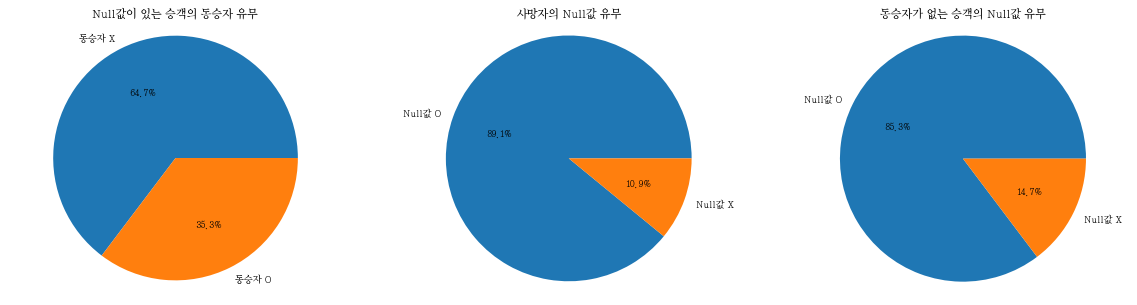

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].set_title('Null값이 있는 승객의 동승자 유무')
ax[0].pie([Null_Alone_num, len(Null_ID)-Null_Alone_num],labels = ['동승자 X', '동승자 O'],autopct ='%1.1f%%')
ax[0].axis('equal')


ax[1].set_title('사망자의 Null값 유무')
ax[1].pie([Dead_Null_num, Dead_num-Dead_Null_num],labels = ['Null값 O', 'Null값 X'] ,autopct ='%1.1f%%')
ax[1].axis('equal')

ax[2].set_title('동승자가 없는 승객의 Null값 유무')
ax[2].pie([Alone_Null_num, len(Alone_ID)- Alone_Null_num],labels = ['Null값 O', 'Null값 X'], autopct = '%1.1f%%')
ax[2].axis('equal')

plt.show()

-------------------------
null값이 있는 승객(708명) 중 동승자가 없는 승객은 458명이다.(약 65%)

사망자(549명) 중 null값이 있는 승객은 489명이다.(89%)

동승자가 없는 승객(537명) 중 null값이 있는 승객은 458명이다.(85%)

<strong>즉, 동승자가 없는 승객은 null값이 있을 확률이 높다.</strong>

In [31]:
#동승자가 없는 승객의 정보
Alone_df = pd.DataFrame() 
for i in ['PassengerId','Age','Pclass', 'Sex','Embarked','Fare','Cabin','Survived']:
    Alone_df[i] = train[train.PassengerId.isin(Alone_ID)][i]
Alone_df.head(10)

,PassengerId,Age,Pclass,Sex,Embarked,Fare,Cabin,Survived
2,3,26.0,3,female,S,7.9250,NaN,1
4,5,35.0,3,male,S,8.0500,NaN,0
5,6,NaN,3,male,Q,8.4583,NaN,0
6,7,54.0,1,male,S,51.8625,E46,0
11,12,58.0,1,female,S,26.5500,C103,1
12,13,20.0,3,male,S,8.0500,NaN,0
14,15,14.0,3,female,S,7.8542,NaN,0
15,16,55.0,2,female,S,16.0000,NaN,1
17,18,NaN,2,male,S,13.0000,NaN,1
19,20,NaN,3,female,C,7.2250,NaN,1


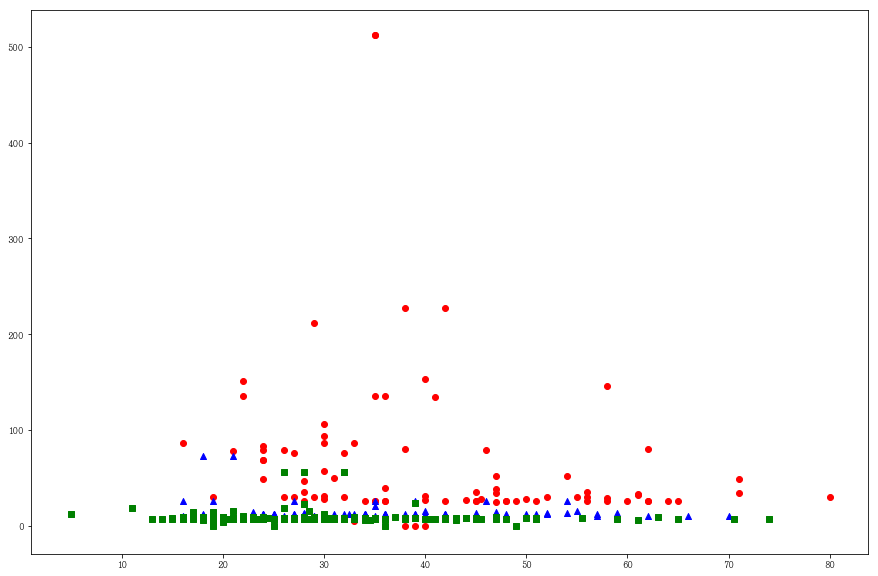

In [32]:
c = {1 : 'r', 2 : 'b', 3:'g'}
m = {1 : 'o', 2 : '^', 3:'s'}
plt.figure(figsize=[15,10])
# Alone_df['Embarked'] = Alone_df['Embarked'].astype('category')
# Alone_df['Embarked'].cat.categories = [1,2,3]
for i in range(1,4):
    plt.scatter( Alone_df.loc[Alone_df.Pclass == i].Age\
                , Alone_df.loc[Alone_df.Pclass==i].Fare, color = c[i], marker = m[i], label =i, zorder = 100)

---------------------------
Null값의 유무와 사망여부, 동승자 유무는 서로 상관관계를 보이고 있다.


- Null값이 있는 승객 중 사망자는 69.1%


- Null값이 있는 승객 중 혼자인 승객은 64.7%


- 사망한 승객 중 혼자인 승객은 68.1%


- 사망한 승객 중 Null값이 있는 승객은 89.1%


- 사망한 승객 중 혼자이고 Null값이 있는 승객은 62.5%


- 혼자인 승객 중 사망자는 69.6%


- 혼자온 승객 중 Null값이 있는 승객은 85.3% 


- 사망했고, 혼자 온 승객 중 null값이 있는 승객은 91.7%


- 혼자왔고 null값이 있는 승객 중 사망자는 74.9%

정리하자면,


사망한 승객은 대부분은 Null값이 있고,

혼자온 승객은 Null값이 있을 확률이 높고,


혼자 + Null값이 있는 승객일 경우 사망했을 가능성이 높다.

혼자+Null값 있는 승객일 때 사망할 확률: 74.9%
사망자 일때 혼자+Null값이 있는 승객일 확률 :62.5% 
사망자 일때 동승자가 있고 Null값이 없는 승객일 확률:
사망자 일 때 동승자가 있는 승객일 확률:
사망자 일 때 Null값이 없는 승객일 확률:

In [33]:
Null_df = pd.DataFrame(deepcopy(train))
Null_df = Null_df.drop(['Parch','SibSp'], axis = 1)
Null_df['Alone']  = [0 for _ in range(891)]
Null_df.loc[Null_df.PassengerId.isin(Alone_ID), 'Alone'] = 1
Null_df = Null_df.drop(['Name', 'Ticket'], axis = 1)
#여자는 0 , 남자는 1
Null_df.loc[Null_df.Sex == 'female', 'Sex'] =0
Null_df.loc[Null_df.Sex == 'male', 'Sex'] =1
Null_df.head(10)

KeyError: "['Name'] not found in axis"

In [ ]:
plt.figure(figsize = (10,10))
parallel_coordinates(Null_df.drop(['PassengerId'Cabin, Embarked], axis=1),'Alone',color=('r','b'),alpha = 0.5 )
plt.show()

In [ ]:
ageSurv = defaultdict(int)
ageDead = defaultdict(int)
SexSurv = defaultdict(int)
for age, surv in zip(train.loc[train.SibSp == 0].loc[train.Parch == 0].loc[train.Age.isnull() | train.Cabin.isnull() | train.Embarked.isnull()].Age, train.loc[train.SibSp == 0].loc[train.Parch == 0].loc[train.Age.isnull() | train.Cabin.isnull() | train.Embarked.isnull()].Survived):
    if surv == 1:
        ageSurv[AgeClassify(age)] += 1
    else:
        ageDead[AgeClassify(age)] += 1
print("ageDead: {}".format(ageDead))
print("ageSurv: {}".format(ageSurv))

In [ ]:
pd.DataFrame(ageSurv.values(),index=ageSurv.keys()).plot.barh()

In [ ]:
343/458

### 점수
- 혼자 + Null값이 있는 승객이면 사망(0)에 +1

## Cabin과 사망 여부의 상관관계
알파벳별로 Cabin(객실번호)을 분류하여 분석하기

In [ ]:
train.Cabin.value_counts().head(10)

In [129]:
#각 객실을 알파벳으로 분류하고 생존율 계산 
#각 객실에 묵은 사람들의 수, 생존자 수
num = defaultdict(int)
surv = defaultdict(int)
for i,j in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].Survived) :
    num[i[0]] += 1
    surv[i[0]] += j
    
total = defaultdict(int)
for i in surv.keys():
    total[i] = surv[i]/num[i]

print('{}: {}'.format('각 객실별 승객 수',list(sorted(num.items()))))
total= pd.DataFrame(list(sorted(total.items())), index = list(sorted(total)))
total

각 객실별 승객 수: [('A', 15), ('B', 45), ('C', 59), ('D', 33), ('E', 32), ('F', 13), ('G', 4), ('T', 1)]


,0,1
A,A,0.466667
B,B,0.733333
C,C,0.593220
D,D,0.757576
E,E,0.750000
F,F,0.615385
G,G,0.500000
T,T,0.000000


----------------------------------------------
각 객실별(알파벳으로 분류) 생존확률을 나타내보았다. 

<strong>B,D,E로 시작하는 객실들의 생존확률</strong>은 70%가 넘는다. 이 객실에 묵은 승객들의 정보가 궁금하다.


### B,D,E에 묵은 승객들은 어떤 승객들인가?

In [ ]:
bdetmp = train.loc[train.Cabin.notnull()]
ageT = defaultdict(int)
for i in bdetmp.loc[bdetmp.Age.notnull()].Age:
    ageT[AgeClassify(i)] += 1

plt.figure(figsize=(10, 7))
plt.title('B,D,E로 시작하는 객실 승객의 연령대')
# plt.pie(ageT.values(),labels = ["{}대".format(i) for i in ageT.keys()],autopct ='%1.1f%%')
# plt.axis('equal')
# mpl.rcParams['font.size'] = 10.0
plt.bar(ageT.keys(), ageT.values())

In [ ]:
plt.figure(figsize=(10, 7))
plt.pie(ageT.values(),labels = ["{}대".format(i) for i in ageT.keys()],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 10.0

-----------------------------
30대(27%)가 가장 많고 20대(19.5%), 40대(17.8%), 50대(13%) 순으로 많다.

In [ ]:
ttmp = defaultdict(int)
dtmp = defaultdict(int)
for a, t in zip(bdetmp.loc[bdetmp.Age.notnull()].Age,bdetmp.loc[bdetmp.Age.notnull()].Survived):
    ttmp[AgeClassify(a)] += t
    if t == 0:
        dtmp[AgeClassify(a)] += 1

total = defaultdict(int)
for k in range(0,90,10):
    try:
        total[k] = 100*ttmp[k]/(ttmp[k]+dtmp[k])
    except:
        continue
total

In [ ]:
plt.title('연령대별 생존율')
plt.plot(total.keys(), total.values())

-----------------------------------
70대는 모두 사망(2명)했고, 80대는 모두 생존(1명)했다.


0~30대는 비교적 높고 비슷한 생존율을 유지하다가 40대부터 급격히 낮아지기 시작한다.

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 Pclass')
plt.pie(bdetmp.Pclass.value_counts(),labels = [1,2,3],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 12.0

-------------------------------
86.3% 즉 대부분의 해당 객실 승객 사회적 지위가 높다.

In [ ]:
plt.figure(figsize = (15,7))
plt.title('Pclass에 따른 Fare분포')
sns.violinplot(x = bdetmp.Pclass, y = bdetmp.Fare )

-----------------------------------------
사회적 지위가 높을 수록 더 높은 요금을 내는 사람들이 많다. 



따라서<strong> Pclass가 높을 수록 Fare도 높을 확률이 높다.</strong>

In [ ]:
bdetmp.Fare.describe()#B,D,E 승객의 Fare 정보

In [ ]:
train.Fare.describe()#전체승객의 Fare 정보

-----------------------------------------
평균값을 보아도, 사분위수를 보아도 B,D,E 승객이 비싼 요금을 낸다는 것을 알 수 있다.


그리고 가장 비싼 요금을 낸 사람도 B,D,E 승객중에 있다.

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 Embarked')
plt.pie(bdetmp.Embarked.value_counts(),labels = ['S','C','Q'],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 12.0

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 성별')
plt.pie(bdetmp.Sex.value_counts(),labels = ['male','female'],autopct ='%1.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
train.

-------------------------------
승선항구는 S가 64%로 가장 많고, Q는 2%로 거의 없는 편이다.


성별은 남성이 52%, 여성이 48%를 차지하고 있다.

------------------------------
## 결론
B,D,E로 시작하는 객실에 묵은 승객들의 <strong>생존확률이 70%가 넘는다</strong>는 사실을 알게 되었다.

그래서 해당 객실 승객들의 나이, 성별, 사회적 지위, 요금, 승선한 항구에 대해 알아보았다.

정리를 하자면,


나이는 20~40대가 가장 많고, 0~50대가 전체의 93%를 차지한다.



성별비율은 거의 1:1이다.



사회적 지위는 <strong>대부분(86%)이 1등급</strong>이다.



<strong>비싼 요금을 낸 승객들은 모두 사회적 지위가 높은 승객들이고, 이 승객들은 해당 객실에 포함</strong>되어 있다.



승선 항구는 S항구가 가장 많고(64%), Q항구는 거의 없다(2%)


여기서 가장 눈에 띄는 것은, 해당 객실 승객들이 대부분 <strong>사회적 지위가 높은 사람들</strong>이라는 것이다.


그리고 이 사회적 지위가 높은 사람들은 대부분 <strong>높은 요금</strong>을 지불했다.


그래서 해당 객실 승객들의 생존확률이 높은 것에 가장 큰 영향을 준 것은 <strong>Pclass와 Fare</strong>이고, B,D,E로 시작하는 객실은 비싸고 좋은 객실이었을 것이라 생각한다.


### 점수
Cabin은 train뿐만 아니라 test데이터도 많은 양이 누락되어 있다.

그래서 다음과 같이 점수를 부여할 것이다.

1. Cabin 값이 B,D,E 중 하나고 Pclass도 높다면 생존(1)에 +1
2. Cabin 값이 없고, Pclass가 1이고 Fare가 B,D,E승객의 평균보다 높다면 생존(1)에  +0.5
3. Pclass가 2이하이고, Fare가 전체 평균보다 낮다면 사망(0)에 +0.5 


## Age

- Age_dict : key는 나이, value는 나이가 key인 사람의 수


- Age_Survived_dict : key는 나이, value는 나이가 key인 생존자 수 

In [ ]:
#전체 나이 분포
Age_dict = defaultdict(int)
for i in list(train.loc[train.Age.notnull()].Age):
    Age_dict[i] += 1
plt.figure(figsize=(15, 5))
plt.title('전체 나이 분포')
plt.scatter(Age_dict.keys(), Age_dict.values(),s = 15,c='g')
plt.xlabel('Age')
plt.ylabel('Count')

----------------------------------------------
10대 후반~ 30대 중후반의 승객이 많아보인다. 

In [ ]:
age2 = defaultdict(int)
for k,v in Age_dict.items():
    age2["{}대".format(AgeClassify(k))] += v
plt.figure(figsize=(6, 6))
plt.title('전체 승객의 연령대')
plt.pie(age2.values(), labels = age2.keys(),autopct ='%1.1f%%')
plt.axis('equal')
plt.show()

--------------------------------------------
20대가 압도적으로 많고, 그다음 30,10,40대 순으로 많다. 

40대 이후로는 점차 줄어들고 있다.


0~40대가 전체의 약 90%를 차지한다.


다음은 연령별로 생존확률을 알아보려고 한다.

In [ ]:
#key: 연령 ,value: 생존자 수
Age_Survived_dict = defaultdict(int)
for i,j in zip(train.loc[train.Age.notnull()].Age, train.loc[train.Age.notnull()].Survived):
    Age_Survived_dict[i] += j
#각 연령별 생존 확률 계산
for k in Age_dict :
    Age_Survived_dict[k] = 100*Age_Survived_dict[k]/Age_dict[k]


In [ ]:
plt.figure(figsize = (18,8))
plt.title('연령별 생존율')
plt.scatter(x= Age_Survived_dict.keys(), y= Age_Survived_dict.values(),s = 5, c = 'g')
plt.ylabel('생존율')
plt.xlabel('나이')

-----------------------------------
<strong>10세 미만인 승객</strong> 중에서는 생존율이 0%인 나이가 하나도 없고, 100%인 나이가 많다.

<strong>10대 후반부터 50대 초반</strong>까지는 생존율이 100%인 나이가 없고, 

주로 0%이거나 20~60%사이의 생존율을 보이고있다.

<strong>60대 중반부터 70대 후반</strong>까지는 생존율이 모두 0%이다.

다음은 <strong>연령대별로 생존자, 사망자</strong>에 대해 분석해볼 것이다.

In [ ]:
#나이 분석을 위한 새로운 DataFrame
#생존자
SAge = pd.DataFrame(columns = [0, 10, 20, 30, 40, 50, 60,70,80],index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
#사망자
DAge = pd.DataFrame(columns = [0, 10, 20, 30, 40, 50, 60,70,80],index = ['count', 'mean', 'std','min', '25%', '50%', '75%', 'max'])

In [ ]:
#생존자
for n in [10,20,30,40,50,60,70,80,90]:
    prev = n-10
    tmp = train.loc[prev<= train.Age ].loc[train.Age < n].loc[train.Survived == 1].Age.describe()
    SAge[prev] = tmp
SAge

In [ ]:
#사망자
for n in [10,20,30,40,50,60,70,80,90]:
    prev = n-10
    tmp = train.loc[prev<= train.Age ].loc[train.Age < n].loc[train.Survived == 0].Age.describe()
    DAge[prev] = tmp
DAge

----------------------------------------------



In [ ]:
38/(38+24)

In [ ]:
#누적 Ticket번호(동승자)
tempC = defaultdict(int)
for i in train.Ticket:
    tempC[i] += 1
family = defaultdict(int)
for k,v in tempC.items():
    if tempC[k] > 1:
        family[k] = v
len(family)

In [ ]:
Fdf= pd.DataFrame()
train.loc[train.Cabin.notnull()].Cabin[:1]

------------------------------
134개의 누적된 Ticket번호가 존재한다. 


즉, 134개 그룹이 탑승했다는 것을 알 수 있다.


그리고 구성원이 7명인 그룹이 가장 크다. 여기서 또 하나의 궁금증이 생겼다. 


'구성원이 많은 그룹일수록 생존확률이 높지않을까?'

## Pclass (사회적 지위)

In [ ]:
plt.title('Pclass에 따른 승객 수')
train.Pclass.value_counts().plot.bar()

--------------------------
Pclass가 3인 즉, 사회적 지위가 가장 낮은 승객이 가장 많고 2인 승객이 가장 적다.

In [ ]:
train.loc[train.Survived == 1, 'Sex'].value_counts()

In [ ]:
train.Cabin.value_counts().head(10)

In [ ]:
train.Ticket.value_counts().head(10)

In [ ]:
train.Embarked.value_counts()

# 예측 모델 만들기

In [ ]:

def Pclass_sol(data, pid, m): #pclass에 따른 점수 부여
    if data[data['PassengerId']== pid].Pclass[0]  == 1:
        return 0.5
#     if data.loc[data.PassengerId == pid].loc[data.Pclass== 1:
#         return 0.5
    elif data.loc[data.PassengerId == pid].Fare[0] >m:
        return 0.2
    return 0
    
def Cabin_sol(data, pid):#B,D,E에 있으면 점수 부여
    for c in data.loc[data.Cabin.notnull()].loc[data.PassengerId == pid].Cabin :  
        #Cabin이 B,D,E에 있으면
        if c[0] in ['B','D','E']:
            return 0.2
    return 0

def Alone_sol(data,pid):
    if data.loc[data.SibSp == 0 & data.Parch == 0].PassengerId == pid:
        return -0.2 - Null_sol(data, pid)
    return 0

def Null_sol(data, pid):
    if data.loc[data.Age.isnull() | data.Cabin.isnull()].PassengerId== pid:
        return -0.2
    return 0

def final_sol(data):
    m = data.Fare.mean()
    tmp = 0   
    res = defaultdict(int)
    for p in data.PassengerId:
        tmp = Pclass_sol(data,p,m) + Cabin_sol(data,p) + Alone_sol(data,p) + Null_sol(data, p)
        if tmp <= 0 :
            res[p] = 0
        else:
            res[p] = 1
    return res

In [ ]:
final_sol(train)